### 1. Purpose of this notebook

The purpose of this notebook is offer a customer segmentation proposal. 

Based on the observations obtained here, we proposed a segmentation based on income and the number of children, two characteristics that appear to have a good correlation with revenue.
We looked at some other features - like buying frequency, but we had no insight from them.

In our segmentation model, we seek to prioritize potential customers to increase revenue.

### 2. Read data

#### 2.1 Import Python packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np

import src.data_visualization as dv
import src.eda as eda
from src.paths import DATA

%matplotlib inline
plt.style.use('bmh')

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv(DATA / 'ml_project1_data_pre_processed.csv')
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Age,MntTotal,NumTotalPurchases,AcceptedTotalFirstFiveCmps,AcceptedTotalFirstFiveCmpsMorePilot,TotalYearAfterRegistration,TotalChildren,DaysOfRegistration,NumTotalPurchasesByMonthRegistred,PurchaseEveryNDays
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,63,1529,22,0,1,8,0,664,0.993976,30.181818
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,66,21,4,0,0,6,2,114,1.052632,28.500000
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,55,734,20,0,0,7,0,313,1.916933,15.650000
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,36,48,6,0,0,6,1,140,1.285714,23.333333
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,39,407,14,0,0,6,1,162,2.592593,11.571429


#### Income

In [3]:
income_not_null_values = df[df['Income'].notnull()]['Income']

In [4]:
q1, q3 = np.percentile(income_not_null_values, [25,75])
iqr = q3 - q1
income_lower_bound = q1 -(1.5 * iqr) 
income_upper_bound = q3 +(1.5 * iqr)

print(f'upper_bound: {income_upper_bound}')
df_income_outliers_removed = df.query(f'Income < {income_upper_bound}')

upper_bound: 118093.5


Corr Income x NumTotalPurchases: 0.78
Corr Income x MntTotal: 0.82


count      2203.000000
mean      51740.775760
std       20614.006076
min        2447.000000
25%       35364.000000
50%       51369.000000
75%       68334.000000
max      113734.000000
Name: Income, dtype: float64

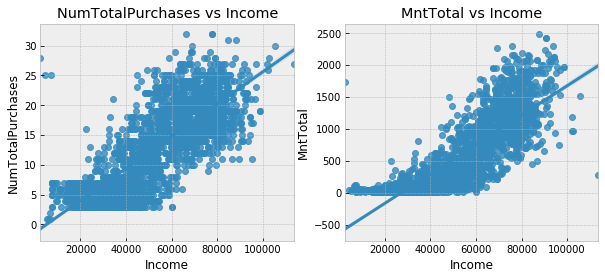

In [5]:
df_income_outliers_removed = df.query(f'Income < {income_upper_bound}')
corr_income_NumTotalPurchases = df_income_outliers_removed['Income'].corr(df_income_outliers_removed['NumTotalPurchases'])
corr_income_MntTotal = df_income_outliers_removed['Income'].corr(df_income_outliers_removed['MntTotal'])

cfig, (ax, ax1) = plt.subplots(1,2, figsize=(10,4))

sns.regplot(x=df_income_outliers_removed['Income'], y=df_income_outliers_removed['NumTotalPurchases'], ax=ax), ax.set_title('NumTotalPurchases vs Income')
sns.regplot(x=df_income_outliers_removed['Income'], y=df_income_outliers_removed['MntTotal'], ax=ax1), ax1.set_title('MntTotal vs Income')
print(f"Corr Income x NumTotalPurchases: {corr_income_NumTotalPurchases:.2f}")
print(f"Corr Income x MntTotal: {corr_income_MntTotal:.2f}")
df_income_outliers_removed['Income'].describe()

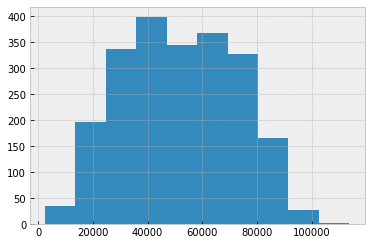

In [6]:
df_income_outliers_removed['Income'].hist();

Looking at the graph, it is possible to observe an apparent positive linear correlation. The person coefficient also shows an apparent correlation.

#### Children

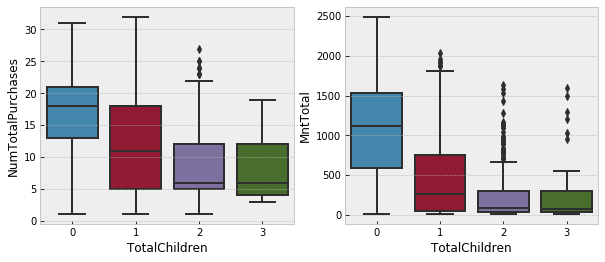

In [7]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(10,4))

sns.boxplot(x=df['TotalChildren'], y=df['NumTotalPurchases'], ax=ax)
sns.boxplot(x=df['TotalChildren'], y=df['MntTotal'], ax=ax1);

Let's check if trere is any relationship between children and MntTotal:

In [8]:
#using bool column
['Corr TotalChildren x MntTotal:',
    df['TotalChildren'].apply(lambda x: 1 if x > 0 else 0).corr(df['MntTotal']).round(2),
 'Corr TotalChildren x NumTotalPurchases:',
df['TotalChildren'].apply(lambda x: 1 if x > 0 else 0).corr(df['NumTotalPurchases']).round(2)]

['Corr TotalChildren x MntTotal:',
 -0.53,
 'Corr TotalChildren x NumTotalPurchases:',
 -0.35]

In [9]:
#Using dummy column
pd.concat([pd.get_dummies(df['TotalChildren']), df['MntTotal']], axis=1).corr()

,0,1,2,3,MntTotal
0,1.000000,-0.634931,-0.302738,-0.098073,0.530532
1,-0.634931,1.000000,-0.485859,-0.157396,-0.229520
2,-0.302738,-0.485859,1.000000,-0.075047,-0.285818
3,-0.098073,-0.157396,-0.075047,1.000000,-0.083137
MntTotal,0.530532,-0.229520,-0.285818,-0.083137,1.000000


Let's remove the outliers.

In [10]:
one_children = eda.remove_outlier(df.query("TotalChildren == 1"), 'MntTotal')
two_children = eda.remove_outlier(df.query("TotalChildren == 2"), 'MntTotal')
three_children = eda.remove_outlier(df.query("TotalChildren == 3"), 'MntTotal')
zero_children = eda.remove_outlier(df.query("TotalChildren == 0"), 'MntTotal')

children_outliers_removed = pd.concat([one_children, two_children, three_children, zero_children])

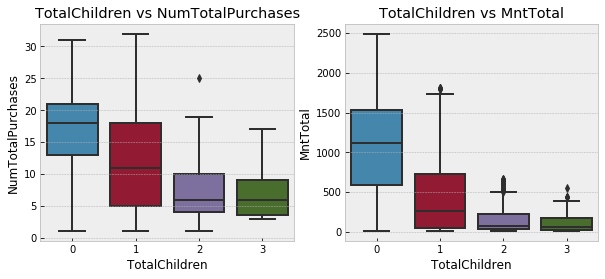

In [11]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(10,4))

sns.boxplot(x=children_outliers_removed['TotalChildren'], y=children_outliers_removed['NumTotalPurchases'], ax=ax), ax.set_title('TotalChildren vs NumTotalPurchases')
sns.boxplot(x=children_outliers_removed['TotalChildren'], y=children_outliers_removed['MntTotal'], ax=ax1),  ax1.set_title('TotalChildren vs MntTotal');

In [12]:
#using bool column
children_outliers_removed_corr = children_outliers_removed['TotalChildren'].apply(lambda x: 1 if x > 0 else 0).corr(children_outliers_removed['MntTotal'])
children_outliers_removed_corr

-0.5562050174460768

Only a small improvement in pearson's correlation was obtained.

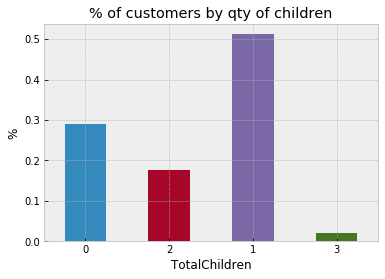

In [13]:
children_outliers_removed['TotalChildren'].value_counts(normalize=True, sort=False).plot.bar()
plt.xticks(rotation=0)
plt.title('% of customers by qty of children')
plt.ylabel("%")
plt.xlabel('TotalChildren');

30% of ours customers have not children.

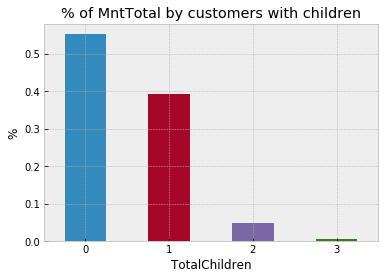

In [14]:
(children_outliers_removed.groupby('TotalChildren')['MntTotal'].sum() 
 / children_outliers_removed['MntTotal'].sum()).plot.bar()
plt.xticks(rotation=0)
plt.title('% of MntTotal by customers with children')
plt.ylabel("%");

This 30% was responsible for more than 55% of revenue.

#### Qty of products purchased

0.2638719794858651

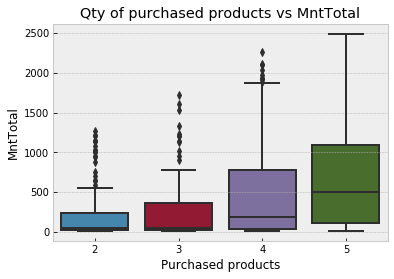

In [15]:
qty_of_products_purchased = (df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']]
                          .applymap(lambda x: 1 if x > 0 else 0)
                          .sum(axis=1)
)
sns.boxplot(x=qty_of_products_purchased, y=df['MntTotal']), 
plt.xlabel("Purchased products"), plt.title('Qty of purchased products vs MntTotal');

qty_of_products_corr = qty_of_products_purchased.corr(df['MntTotal'])
qty_of_products_corr

In [16]:
df['qty_of_products_purchased'] = qty_of_products_purchased

Let's remove the outliers.

0.3202335952485773

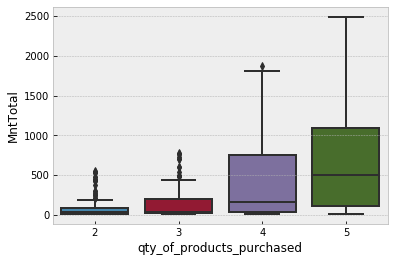

In [17]:
two_products = eda.remove_outlier(df.query("qty_of_products_purchased == 2"), 'MntTotal')
three_products = eda.remove_outlier(df.query("qty_of_products_purchased == 3"), 'MntTotal')
four_products = eda.remove_outlier(df.query("qty_of_products_purchased == 4"), 'MntTotal')
five_products = eda.remove_outlier(df.query("qty_of_products_purchased == 5"), 'MntTotal')


pd_outliers_removed_products = pd.concat([two_products, three_products, four_products, five_products])
sns.boxplot(x=pd_outliers_removed_products['qty_of_products_purchased'], y=pd_outliers_removed_products['MntTotal'])

qty_of_products_purchased_corr = pd_outliers_removed_products['qty_of_products_purchased'].corr(df['MntTotal'])
qty_of_products_purchased_corr

#### Frequency of purchase

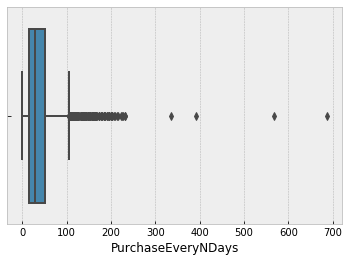

In [18]:
sns.boxplot(x=df['PurchaseEveryNDays']);

Let's remove the outliers.

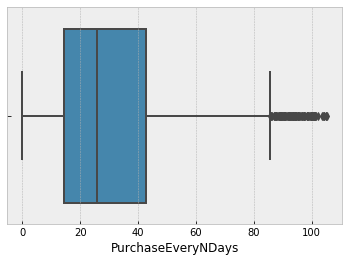

In [19]:
frequency_of_purchase_outlier_removed = eda.remove_outlier(df, 'PurchaseEveryNDays')
sns.boxplot(x=frequency_of_purchase_outlier_removed['PurchaseEveryNDays']);

In [20]:
frequency_of_purchase_corr = frequency_of_purchase_outlier_removed['PurchaseEveryNDays'].corr(frequency_of_purchase_outlier_removed['MntTotal'])
frequency_of_purchase_corr

-0.4211796368415368

#### Average revenue

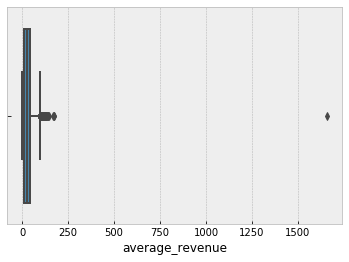

In [21]:
df['average_revenue'] = df['MntTotal']/df['NumTotalPurchases']
sns.boxplot(x=df['average_revenue']);

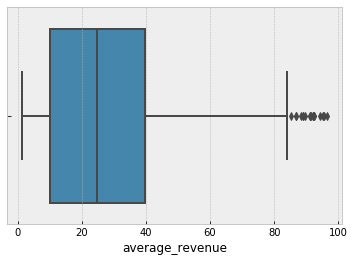

In [22]:
average_revenue_outlier_removed = eda.remove_outlier(df, 'average_revenue')
sns.boxplot(x=average_revenue_outlier_removed['average_revenue']);

count    2107.000000
mean       29.588700
std        22.308621
min         1.520000
25%        10.000000
50%        24.750000
75%        39.744565
max        96.384615
Name: average_revenue, dtype: float64

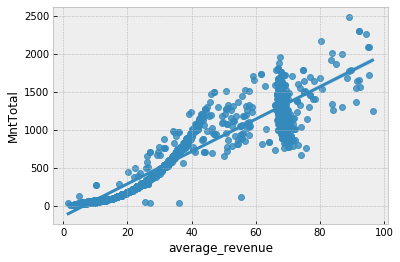

In [23]:
sns.regplot(x=average_revenue_outlier_removed['average_revenue'], y=average_revenue_outlier_removed['MntTotal']);
average_revenue_outlier_removed['average_revenue'].describe()

In [24]:
average_revenue_corr = average_revenue_outlier_removed['MntTotal'].corr(average_revenue_outlier_removed['average_revenue'])
average_revenue_corr

0.9470888728552119

#### All person correlation

In [25]:
pd.DataFrame([corr_income_MntTotal, children_outliers_removed_corr, qty_of_products_purchased_corr, frequency_of_purchase_corr, average_revenue_corr],
             index=['income', 'children', 'qty_of_products', 'frequency_of_purchase', "average_revenue_by_purchase"],
             columns=['Value'])

,Value
income,0.823892
children,-0.556205
qty_of_products,0.320234
frequency_of_purchase,-0.421180
average_revenue_by_purchase,0.947089


#### Segmentation proposal

Our segmentation considers the income and total children. 

The income limits were taken from the distribution of the data.
- For A customers, the 0.85 percentile.
- For B customers, the 0.60 percentile.

Potential customers A (high potential): customers without children and with an income above ~ 75500 (~ 12% of total customers).
Potential customers B (medium potential): customers without children and with an income between ~ 58400 and ~ 75500 (~ 9% of total customers).
Potential customers C (medium potential): customers with children and with an income between ~ 58400 and ~ 75500 (~ 19% of total customers).
Potential customers D (low potential): Other customers.

In [46]:
income_limit = np.percentile(df_income_outliers_removed['Income'], 85)
customers_more_income = df_income_outliers_removed.query(f'Income > {income_limit}')
income_limit

75469.9

331


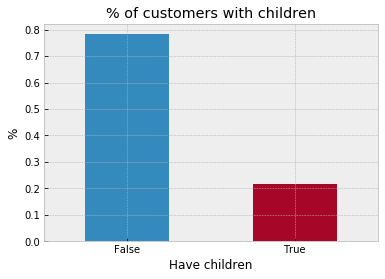

In [39]:
customers_more_income['TotalChildren'].apply(lambda x: True if x > 0 else False).value_counts(normalize=True).plot.bar()
plt.xticks(rotation=0)
plt.title('% of customers with children')
plt.ylabel("%")
plt.xlabel('Have children');

print(customers_more_income['ID'].count())

In [40]:
customers_more_income['MntTotal'].describe()

count     331.000000
mean     1388.232628
std       433.803353
min       274.000000
25%      1080.000000
50%      1360.000000
75%      1698.000000
max      2491.000000
Name: MntTotal, dtype: float64

In [45]:
income_min = np.percentile(df_income_outliers_removed['Income'], 60)
almost_higher_income_customers = df_income_outliers_removed.query(f'Income > {income_min} and Income < {income_limit}')
income_min

58359.6

550


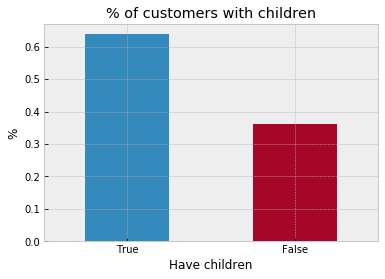

In [42]:
almost_higher_income_customers['TotalChildren'].apply(lambda x: True if x > 0 else False).value_counts(normalize=True).plot.bar()
plt.xticks(rotation=0)
plt.title('% of customers with children')
plt.ylabel("%")
plt.xlabel('Have children');

print(almost_higher_income_customers['ID'].count())

#### % of customers by segment

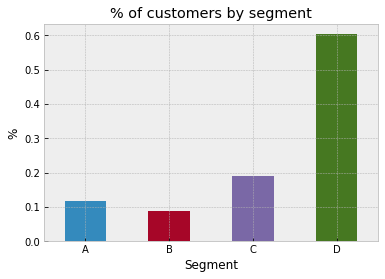

In [43]:
df['Segmentation'] = df.apply(lambda x: eda.classification(x, income_limit, income_min), axis=1)

df['Segmentation'].value_counts(normalize=True).sort_index().plot.bar()
plt.xticks(rotation=0)
plt.title('% of customers by segment')
plt.ylabel("%")
plt.xlabel('Segment');